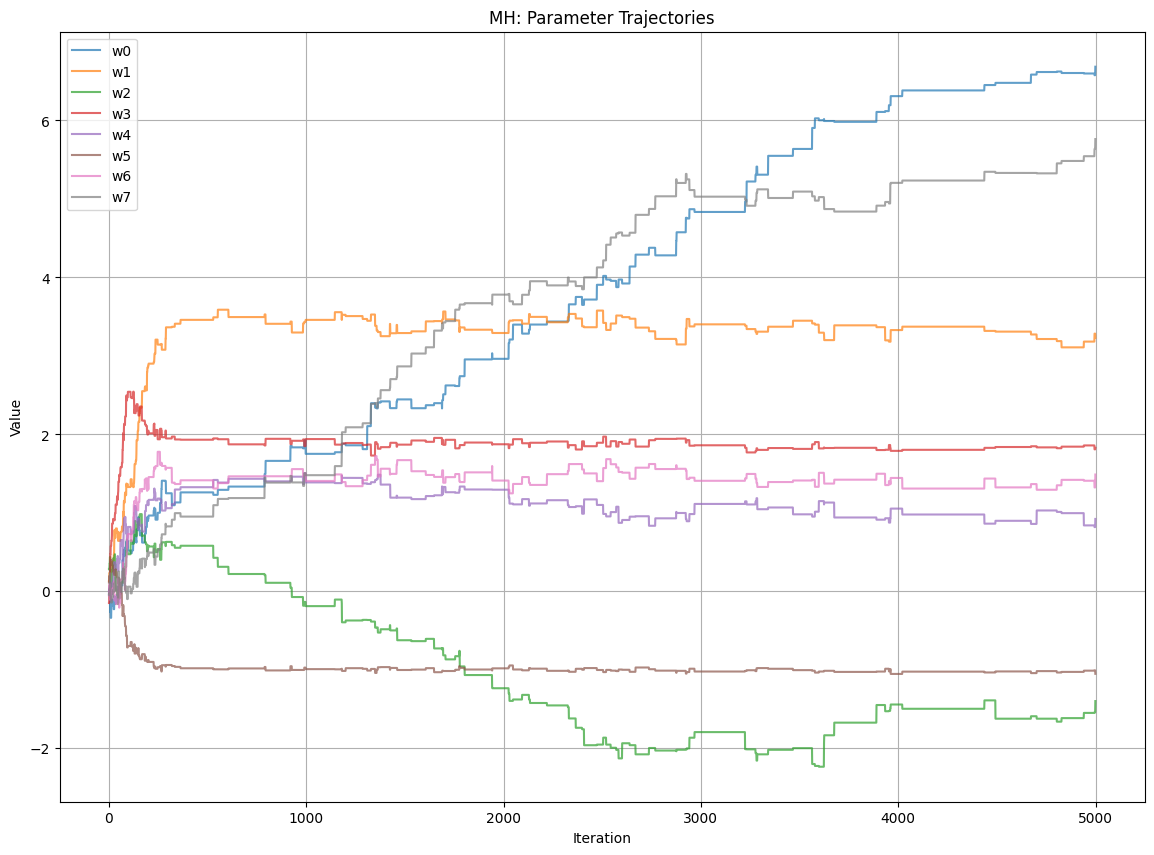

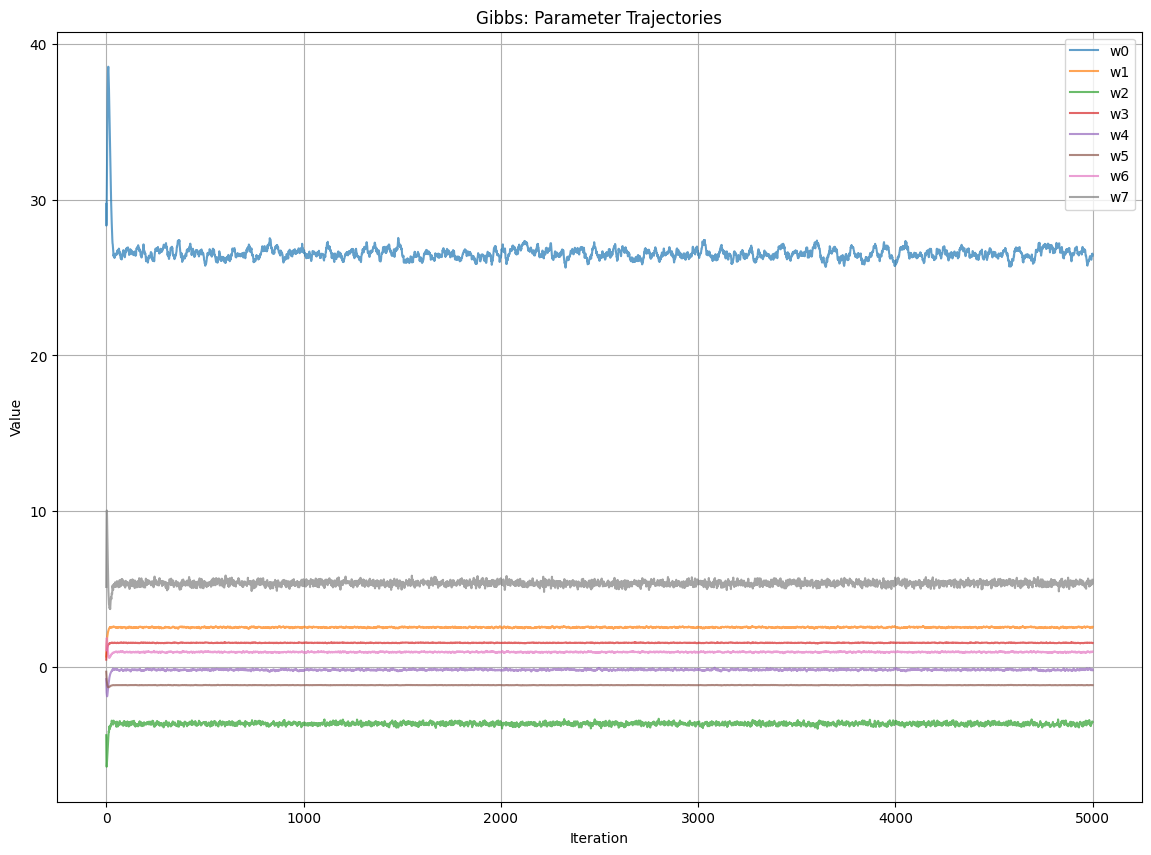

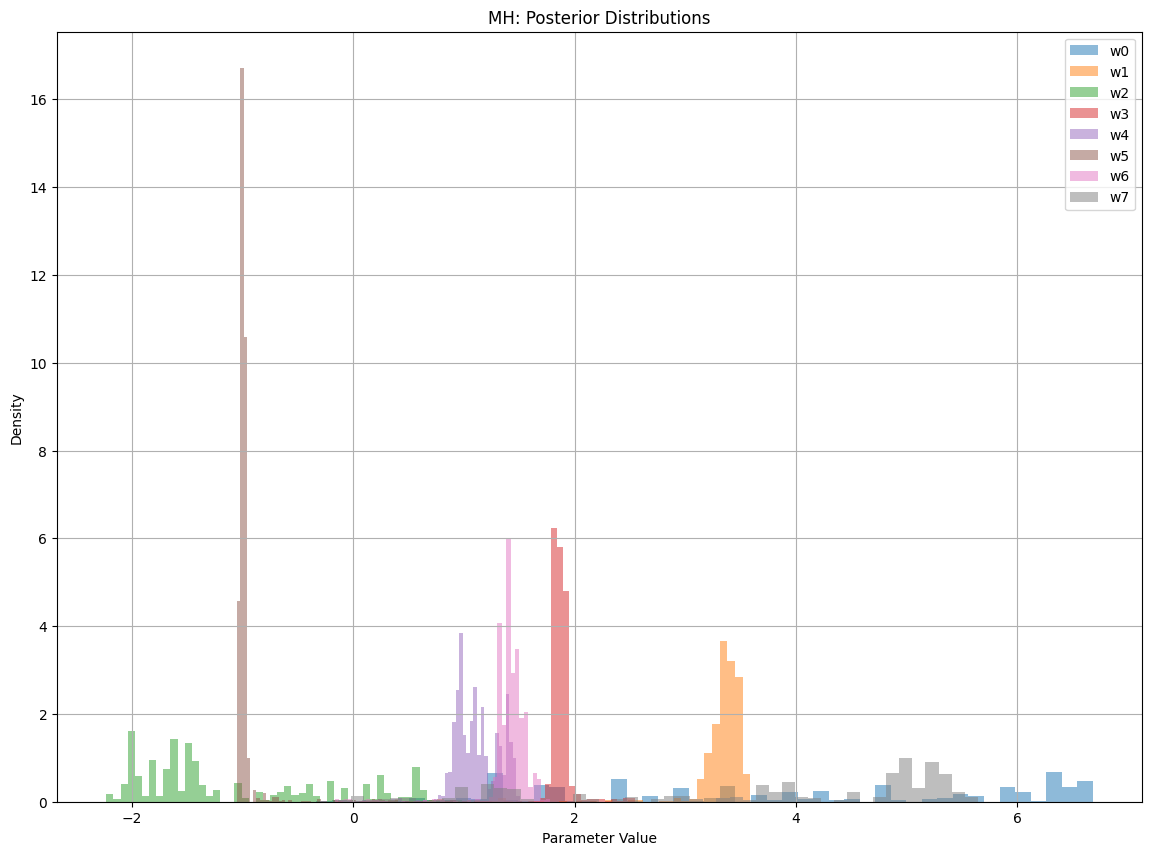

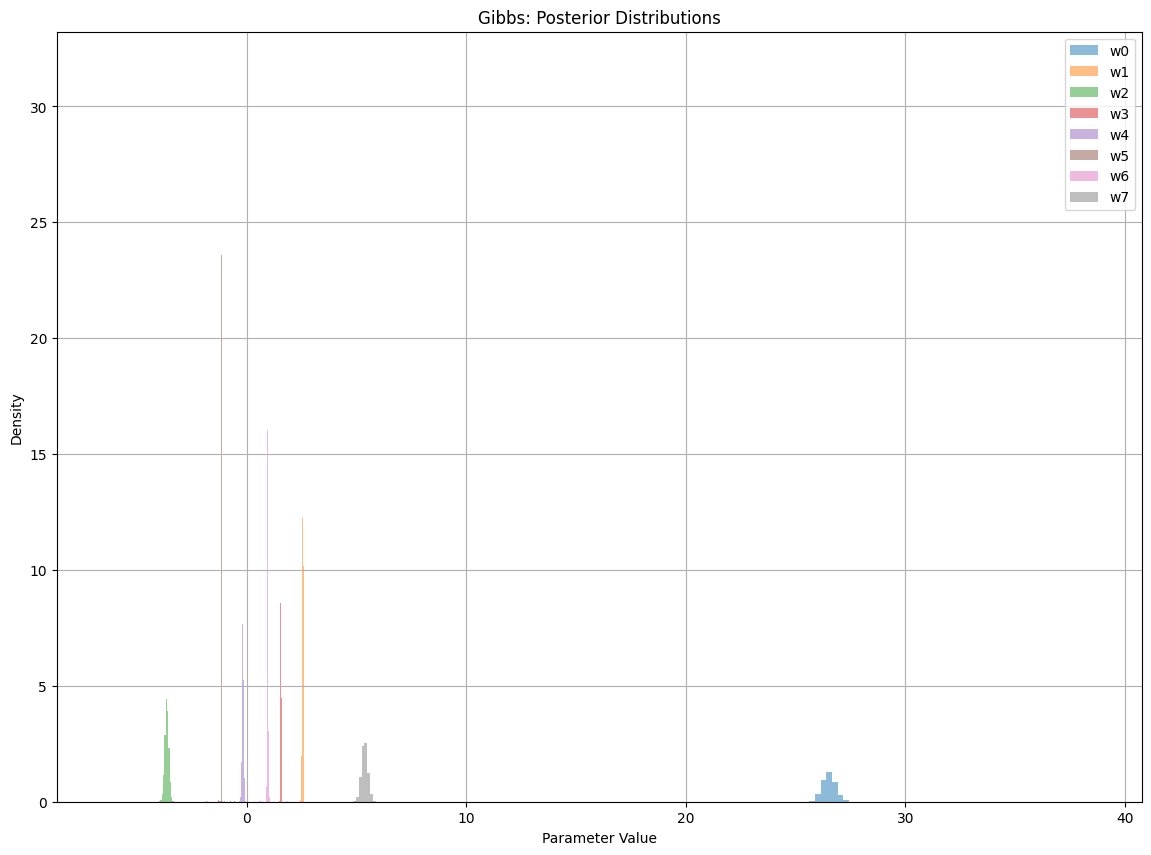

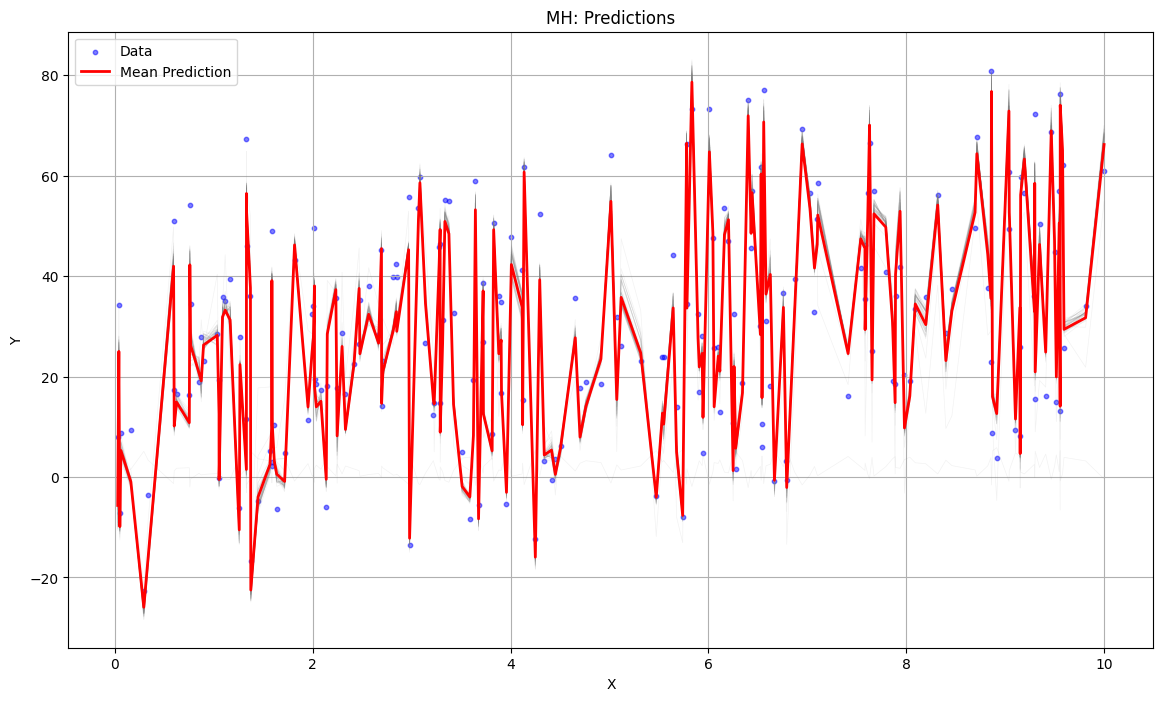

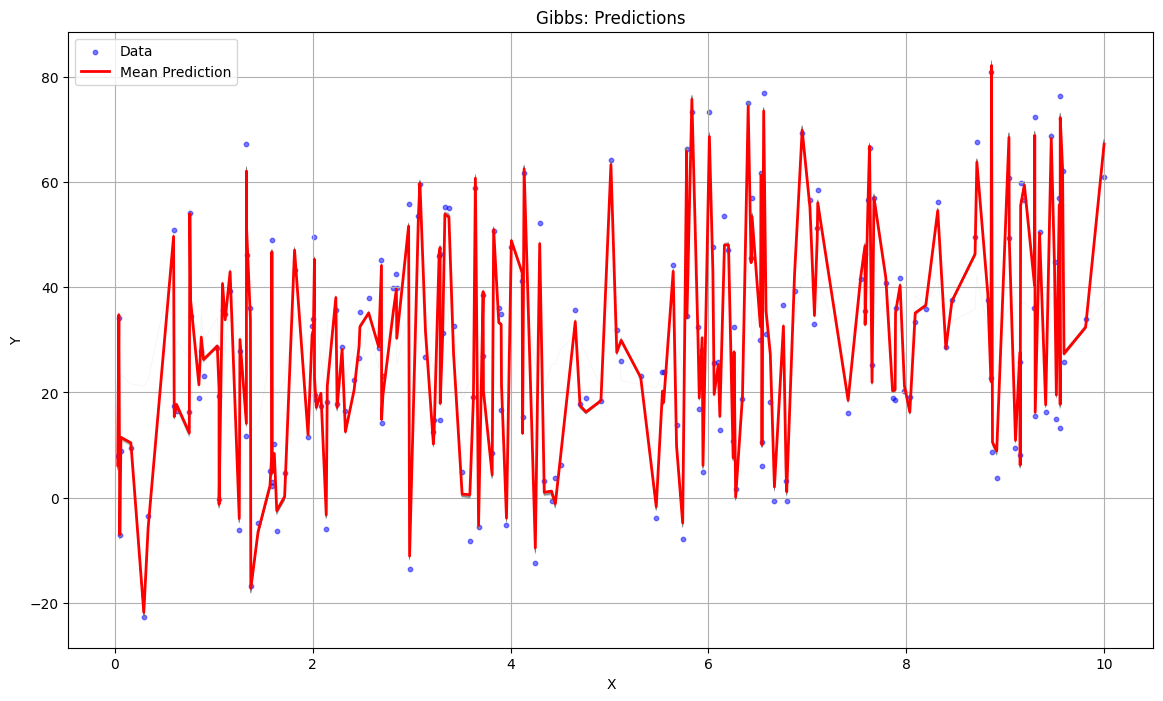

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)
n = 200

x1 = torch.rand(n) * 10
x2 = torch.randint(0, 3, (n,))
x3 = torch.randint(0, 24, (n,))
x4 = torch.randint(1, 8, (n,))
x5 = torch.rand(n) * 50 + 1
x6 = torch.randint(0, 11, (n,))
x7 = torch.randint(0, 100, (n,))
x8 = torch.randint(0, 2, (n,))

init_params = torch.tensor([30.0, 2.5, -4.0, 1.5, -0.3, -1.2, 0.8, 5.0])

target = (
    init_params[0]
    + init_params[1] * x1
    + init_params[2] * x2.float()
    + init_params[3] * x3.float()
    + init_params[4] * x4.float()
    + init_params[5] * x5
    + init_params[6] * x6.float()
    + init_params[7] * x8.float()
    + torch.normal(0, 3, (n,))
)

features = torch.stack([
    torch.ones(n),
    x1,
    x2.float(),
    x3.float(),
    x4.float(),
    x5,
    x6.float(),
    x8.float()
], dim=1)

def calc_posterior(params):
    pred = torch.matmul(features, params)
    ll = -0.5 * torch.sum((target - pred) ** 2)
    lp = -0.5 * torch.sum(params**2)
    return ll + lp

def mh_sampler(n_iter=10000, std=0.1):
    result = []
    curr = torch.zeros(8)
    for _ in range(n_iter):
        prop = curr + torch.normal(0, std, size=(8,))
        ratio = calc_posterior(prop) - calc_posterior(curr)
        if torch.log(torch.rand(1)) < ratio:
            curr = prop
        result.append(curr.clone())
    return torch.stack(result)

def gibbs_sampler(n_iter=10000):
    result = []
    curr = torch.zeros(8)
    for _ in range(n_iter):
        for i in range(8):
            res = target.clone()
            for j in range(8):
                if j != i:
                    res -= curr[j] * features[:, j]
            feat = features[:, i]
            sum_res = torch.dot(feat, res)
            sum_sq = torch.sum(feat ** 2)
            mu = sum_res / (sum_sq + 1.0)
            sigma = 1.0 / (sum_sq + 1.0)
            curr[i] = torch.normal(mu, torch.sqrt(sigma))
        result.append(curr.clone())
    return torch.stack(result)

mh_samples = mh_sampler(n_iter=5000)
gibbs_samples = gibbs_sampler(n_iter=5000)

labels = ["w0", "w1", "w2", "w3", "w4", "w5", "w6", "w7"]

plt.figure(figsize=(14, 10))
for i in range(8):
    plt.plot(mh_samples[:, i], label=labels[i], alpha=0.7)
plt.title("MH: Parameter Trajectories")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14, 10))
for i in range(8):
    plt.plot(gibbs_samples[:, i], label=labels[i], alpha=0.7)
plt.title("Gibbs: Parameter Trajectories")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14, 10))
for i in range(8):
    plt.hist(mh_samples[:, i].numpy(), bins=50, alpha=0.5, label=labels[i], density=True)
plt.title("MH: Posterior Distributions")
plt.xlabel("Parameter Value")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14, 10))
for i in range(8):
    plt.hist(gibbs_samples[:, i].numpy(), bins=50, alpha=0.5, label=labels[i], density=True)
plt.title("Gibbs: Posterior Distributions")
plt.xlabel("Parameter Value")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

def plot_preds(samples, title):
    x_np = x1.numpy()
    y_np = target.numpy()
    preds = [torch.matmul(features, sample).numpy() for sample in samples[::100]]

    plt.figure(figsize=(14, 8))
    for pred in preds:
        idx = np.argsort(x_np)
        plt.plot(x_np[idx], pred[idx], color="gray", alpha=0.1, linewidth=0.5)
    plt.scatter(x_np, y_np, color="blue", s=10, label="Data", alpha=0.5)

    mean_pred = np.mean(preds, axis=0)
    plt.plot(x_np[idx], mean_pred[idx], color="red", linewidth=2, label="Mean Prediction")

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid()
    plt.show()

plot_preds(mh_samples, "MH: Predictions")
plot_preds(gibbs_samples, "Gibbs: Predictions")


Различия алгоритмов: Гиббс быстрее, если есть сопряжённые априоры — сразу обновляет параметры. Метрополис-Хастингс же требует настройки и часто медленнее сходится

Эффективность: Гиббс за счёт точных распределений сходится быстро. М-Х нужен дольше для стабильности

Как ускорить:
- диагональная ковариация: проще считать, если параметры почти не связаны
- регуляризация: маленькие дисперсии априоров — стабильнее оценки